<div align="center">
<h1>Loop Q Prize</h1>
<h2 >Challenge A</h2>
    <h3>Solution by Alexandros P. Pouroullis</h3>
<div>

<h1>Loading the data</h1>

In [509]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.io import wavfile
import os
import pandas as pd
import numpy as np
import IPython.display as ipd
import librosa
import librosa.display
import glob
from IPython.display import Audio

In [472]:
train_audio_path = "./challengeA_data/train"
train_csv_path = "./challengeA_data/2022challengeA_train.csv"
test_audio_path = "./challengeA_data/test"
test_csv_path = "./challengeA_data/2022challengeA_test.csv"

In [473]:
train_df = pd.read_csv(train_csv_path, index_col=[0])
test_df = pd.read_csv(test_csv_path, index_col=[0])

train_df.head()

,file_id,emotion,origin
0,ae2e1c07-4ad7-4bc5-bdac-d3dcf0c8673b.wav,fear,crema
1,08c8ea7c-7f81-41fb-8dfa-eaff9d3c292b.wav,fear,crema
2,f28d06ce-1929-40c4-8c40-7a7671d8c0ab.wav,sadness,crema
3,8934caea-8409-4034-ae41-fa8552e2c3d6.wav,disgust,crema
4,d53575a9-dd20-45c8-a45f-a08e2ad93b9e.wav,neutral,crema


In [474]:
test_df.head()

,file_id,origin,predicted_emotion
0,030472df-9d70-4d76-a1a5-acb4c33537d3.wav,crema,NaN
1,ac4720de-e0d9-4667-86a7-4236d410ed25.wav,crema,NaN
2,264928af-cb15-4125-abf7-9408369d83b2.wav,crema,NaN
3,2233ce2b-35ae-483c-9397-1058f681b6ef.wav,crema,NaN
4,472aa1eb-b4dc-452c-84b7-934ed61285da.wav,crema,NaN


<h1>Data exploration and cleaning</h1>

In [475]:
train_df.isnull().sum()

file_id    0
emotion    1
origin     0
dtype: int64

In [476]:
# Checking if there is a mismatch of files in the train metadata dataframe and the dataset directory
file_ids_set = set(train_df["file_id"])
audio_files_list = glob.glob(os.path.join(train_audio_path, "*.wav"))
audio_files_list = [file.replace(train_audio_path+"/", "") for file in audio_files_list]
audio_files_set = set(audio_files_list)

files_diff_file_ids = file_ids_set.difference(audio_files_set)
files_diff_audio_files = audio_files_set.difference(file_ids_set)
print("Number of file ids present in training metadata dataframe not present in training dataset:", len(files_diff_file_ids))
print("Number of audio file names present in training dataset not present in training metadata dataframe:", len(files_diff_audio_files))

Number of file ids present in training metadata dataframe not present in training dataset: 1
Number of audio file names present in training dataset not present in training metadata dataframe: 0


One file is missing a label and the training metadata dataframe contains one file id that isn't present in the training dataset. I'll find the indexes in the training metadata dataframe of these two occurrences and remove them.

In [477]:
missing_file = list(files_diff_file_ids)[0]
print("Index of instance with missing emotion:")
print(train_df[train_df.isnull().any(axis=1)].index[0])
print()
print("Index of instance with file id not present in training dataset:")
print(train_df.loc[train_df["file_id"] == missing_file].index[0])

Index of instance with missing emotion:
8937

Index of instance with file id not present in training dataset:
8937


It appears that the record with the missing label is also the instance with the file id that isn't present in the training dataset. I'll remove this record from the dataframe.

In [478]:
print("Number of instances before removal:", len(train_df.index))

for missing_file in missing_training_files:
    missing_file_index = train_df.loc[train_df["file_id"] == missing_file].index
    train_df.drop(index=missing_file_index, axis=0, inplace=True)

print("Number of instances after removal:", len(train_df.index))

Number of instances before removal: 10111
Number of instances after removal: 10110


We can see that the instance was successfully removed from the dataframe. I'll reset the indexes of the training metadata dataframe because the removed instance leaves a gap in the indexes.

In [479]:
train_df.reset_index(drop=True, inplace=True)

In [480]:
train_df.isnull().sum()

file_id    0
emotion    0
origin     0
dtype: int64

And to verify that what I did worked, I printed the counts of null values in the dataframe; it indeed worked.

I want to get the class distribution for the emotions. One way to go about doing this is simply to group the dataframe by emotion and get the counts for each emotion, but this wouldn't tell us the full story if the sound files are of varying duration, because sound files of a greater duration provide more information in training. I'll first check if the duration of files vary. If this is the case, then I will get the mean duration for each emotion and plot the distribution. The distribution is important, because if there is a substantial imbalance in the representations of emotions, the model will be biased towards those emotions that it saw more of. Thus, it will need to be addressed later on in the preprocessing phase, where I'd likely use something like data augmentation to add more instances to the underrepresented emotions.

In [481]:
# Displaying a the durations of a sample of audio files.
print("Durations of a sample of 10 audio files:")
print("-"*40)
for audio_file_name in train_df.sample(n=10)["file_id"]:
    audio_file_path = os.path.join(train_audio_path, audio_file_name)
    try:
        # Specifying None for sr uses the native sample rate of the audio file, which in this case
        # is 16kHz.
        samples, sample_rate = librosa.load(audio_file_path, sr=None)
        duration = librosa.get_duration(y=samples, sr=sample_rate)
        print("{0:.2f}s".format(duration))
    except FileNotFoundError:
        file_id = audio_file_name.replace(".wav", "")
        print(f"File with id {file_id} is missing from the training dataset.")


Durations of a sample of 10 audio files:
----------------------------------------
1.92s
2.34s
3.10s
3.04s
2.27s
3.24s
1.96s
2.54s
2.94s
4.79s


The durations of the audio files do indeed vary. I'll append a column specifying the duration of the audio files in the training metadata dataframe so I can get the mean duration of the audio files for each emotion.

In [482]:
duration_column = pd.Series([], dtype="float64")
for audio_file_name in train_df["file_id"]:
    audio_file_path = os.path.join(train_audio_path, audio_file_name)
    try:
        samples, sample_rate = librosa.load(audio_file_path, sr=None)
        duration = librosa.get_duration(y=samples, sr=sample_rate)
        duration_column = pd.concat([duration_column, pd.Series(duration, dtype="float64")], ignore_index=True)
    except FileNotFoundError:
        file_id = audio_file_name.replace(".wav", "")
        print(f"File with id {file_id} is missing from the training dataset.")
        
duration_column = duration_column.rename("duration")
duration_column


0        2.669313
1        2.569250
2        2.902875
3        2.035375
4        2.268937
           ...   
10105    1.969649
10106    1.311911
10107    2.402720
10108    1.933972
10109    2.178873
Name: duration, Length: 10110, dtype: float64

In [483]:
train_df = pd.concat([train_df, duration_column.rename("duration")], axis=1, )
train_df

,file_id,emotion,origin,duration
0,ae2e1c07-4ad7-4bc5-bdac-d3dcf0c8673b.wav,fear,crema,2.669313
1,08c8ea7c-7f81-41fb-8dfa-eaff9d3c292b.wav,fear,crema,2.569250
2,f28d06ce-1929-40c4-8c40-7a7671d8c0ab.wav,sadness,crema,2.902875
3,8934caea-8409-4034-ae41-fa8552e2c3d6.wav,disgust,crema,2.035375
4,d53575a9-dd20-45c8-a45f-a08e2ad93b9e.wav,neutral,crema,2.268937
...,...,...,...,...
10105,78c8debb-0538-4d48-a3f8-0a33b5978e42.wav,surprise,tess,1.969649
10106,2636304a-47c8-486e-a43b-6ac16ecf5798.wav,fear,tess,1.311911
10107,b9291006-74b0-43dc-bea1-8a6a1527ccdb.wav,disgust,tess,2.402720
10108,de13c5a0-6a9a-4287-a0c8-f0183d1783a3.wav,happy,tess,1.933972


I'll now get the representations of each emotion in the dataset by using the mean durations of each emotion.

In [484]:
emotion_distribution = train_df.groupby("emotion")["duration"].mean()
# Just capitalizing the labels
emotion_distribution.index = [index.capitalize() for index in emotion_distribution.index]

(-1.1147120742426049,
 1.1113125529372911,
 -1.1051796009609807,
 1.100246721600475)

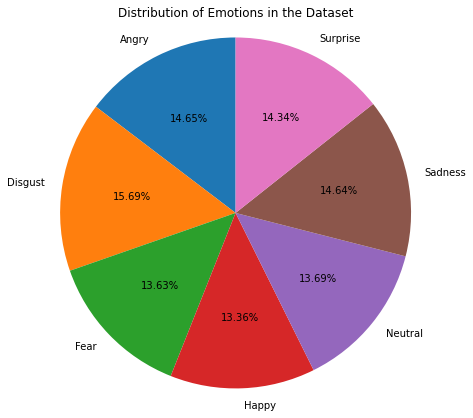

In [485]:
colors = sns.color_palette("tab10", n_colors=10)
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title("Distribution of Emotions in the Dataset")
ax.pie(emotion_distribution, labels=emotion_distribution.index, autopct="%.2f%%", 
       colors=colors[:len(emotion_distribution)], startangle=90)
# Set the aspect ratio to be equal so that the pie chart is drawn as a circle
ax.axis("equal")


In [486]:
train_df["emotion"].value_counts()

angry       1652
happy       1634
disgust     1629
fear        1628
sadness     1555
neutral     1452
surprise     560
Name: emotion, dtype: int64

An interesting discovery made from the above demonstration was that although the number of occurrences of surprise was roughly a 3rd of the number of occurrences of other emotions, the distribution of emotions in terms of duration was roughly uniform. Thus, there's no class imbalance to be addressed.

<h1>Visualising audio</h1>

In [529]:
# Plays a random audio file
random_audio_file = os.path.join(train_audio_path, train_df.sample()["file_id"].values[0])
Audio(random_audio_file)


There are a variety of ways to visualize audio. The simplest is plotting amplitude against time, which I do below.

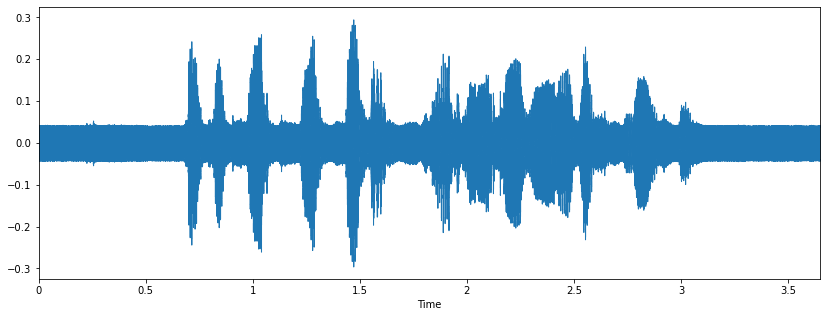

In [532]:
plt.figure(figsize=(14, 5))
samples, sample_rate = librosa.load(random_audio_file, sr=None)   
duration_of_file = librosa.get_duration(y=samples, sr=sample_rate)
plt.xlim([0, duration_of_file])
librosa.display.waveshow(samples, sr=sample_rate);

The issue with the above plot is that it doesn't contain any indication of the frequency content of the audio. To visualize the frequency content of audio through time, we use spectrograms, which displays the intensity of frequencies through time.

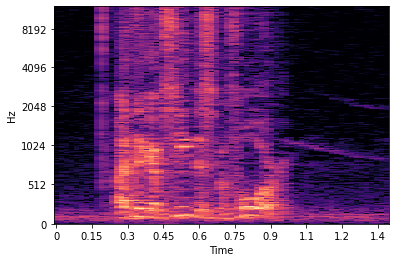

In [508]:
hop_length = 512

D = np.abs(librosa.stft(y, hop_length=hop_length))
Ddb = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(Ddb, sr=sr, x_axis="time", y_axis="mel")

In [162]:
Ddb.shape

(1025, 85)

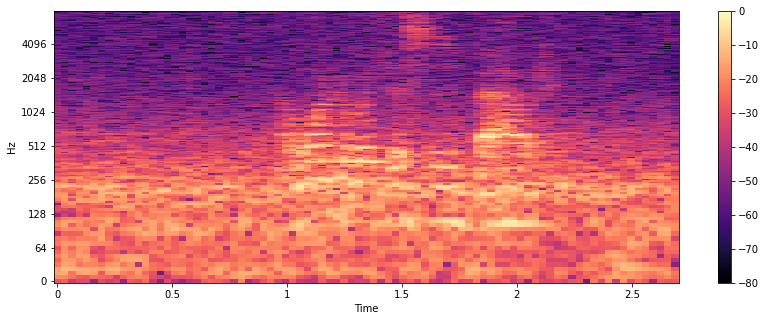

In [113]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(np.abs(X), ref=np.max)
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis="time", y_axis="log")
plt.colorbar();

In [163]:
Xdb.shape

(1025, 85)

In [115]:
import tensorflow
from tensorflow import keras
from keras import layers

In [116]:
tX

array([[-2.4487227e-01+0.j        ,  3.1649947e-01+0.j        ,
         1.0292281e-01+0.j        , ..., -2.9865330e-01+0.j        ,
         2.4422455e-01+0.j        ,  2.6229367e-01+0.j        ],
       [ 6.1832589e-01+0.34256515j, -6.1813170e-01+0.21833676j,
         5.1220696e-02-0.4499179j , ...,  4.6033254e-01+0.1189814j ,
        -4.7014713e-01+0.4381106j , -1.1597054e-02-0.41576535j],
       [-1.1401722e+00+0.15933335j,  1.2820525e+00+0.34867576j,
         1.3960363e-01-0.45028067j, ..., -4.2289010e-01+0.5579182j ,
         8.1878430e-01-0.5661609j , -4.1766366e-01+0.28536016j],
       ...,
       [-7.5821602e-04+0.00350162j, -3.5425106e-03-0.00474024j,
        -8.1220426e-04+0.00215546j, ...,  5.4214038e-03-0.00712701j,
         4.2407683e-04+0.01323909j,  1.8231098e-03-0.00416203j],
       [ 2.7502528e-03+0.00195949j,  7.1579306e-03+0.00332036j,
         6.0198610e-03-0.00309577j, ...,  1.1158463e-02-0.00199945j,
         3.9828834e-03-0.01139164j, -5.8316672e-03+0.00112188j]

In [ ]:
t